## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
data = pd.read_csv('taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [2]:
data.num_orders.describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


### Переведем столбец datetime в формат даты и времени

In [4]:
data.datetime = pd.to_datetime(data.datetime)

### Сделаем столбец с датами - индексами таблицы

In [5]:
data = data.set_index('datetime')

### Отсортируем индексы и проверим их упорядоченность

In [6]:
data = data.sort_index()
print(data.index.is_monotonic)

True


### Ресемплируем дату по одному часу, заказы просуммируем

In [7]:
data = data.resample('1H').sum()
data.head(25)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


# 2. Анализ

### Посмотрим как изменяется кол-во заявок со временем.

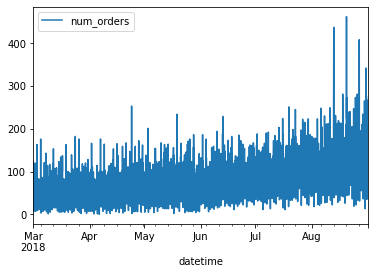

In [8]:
data.plot()

### Для того, чтобы точно понять тренд, добавим скользящее среднее

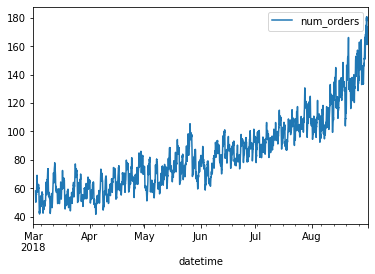

In [9]:
data.rolling(30).mean().plot()

### Тренд возрастающий, кол-во заявок растет от марта к августу. Скорее всего это связано с увеличением кол-ва отпусков к лету.

### Теперь оценим тренд с помощью библтотеки питона :)

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

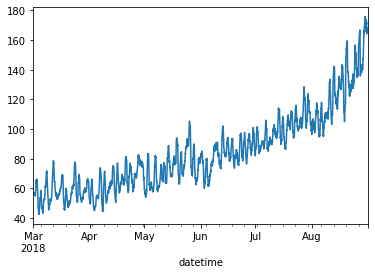

In [11]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot()

### Получаем точно такой же тренд. :)

### Т.к наш датасет идет в разбивке по часам, то для оценки сезонности возьмём небольшую выборку с временным рядом длинной в несколько дней.

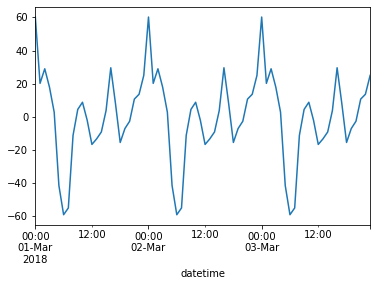

In [12]:
decomposed.seasonal['2018-03-01' : '2018-03-03'].plot()

###  Немного сгладим график скользящим средним

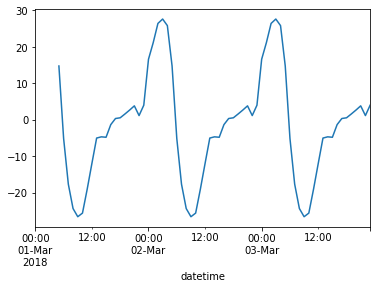

In [13]:
decomposed.seasonal['2018-03-01' : '2018-03-03'].rolling(6).mean().plot()

### Посмотрим немного детальнее (сократим ряд на 1 день)

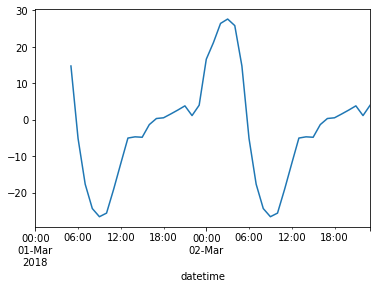

In [14]:
decomposed.seasonal['2018-03-01' : '2018-03-02'].rolling(6).mean().plot()

### Заказы начинаются утром (примерно в 9 часов), растут к вечеру (причем резкий всплеск после 10:00) и достигают пика уже ночью (примерно в 3 часа) или это уже утро?!)), после чего заказы падают и цикл повторяется.

# 3. Обучение

## Создадим функцию, которая будет добавлять признаки в наш датасет.

* 1. Календарные признаки
* 2. Отстающие значения
* 3. Скользящее среднее

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year   # добавить год
    data['month'] = data.index.month # добавить месяц
    data['day'] = data.index.day     # добавить день
    data['dayofweek'] = data.index.dayofweek # добавить день недели
    data['hour'] = data.index.hour   # добавить час
    
    # добавим imax_lag + 1 столбцов со значениями заказов за предыдущие i дней
    for i in range(1, max_lag + 1):
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)

    #добавим скользящее среднее, в расчет берем интервал rolling_mean_size, не включая последнее значение ряда
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [16]:
data = make_features(data, 8, 8).copy() #возьмем lag равный 8 часам и скользящее окно также равное 8 часам
data.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN


#### Удалим строки с пропусками

In [17]:
data = data.dropna()
data.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 08:00:00,34,2018,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.750
2018-03-01 09:00:00,69,2018,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,41.500
2018-03-01 10:00:00,64,2018,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,39.500
2018-03-01 11:00:00,96,2018,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,38.625
2018-03-01 12:00:00,30,2018,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,42.375


### Отделим целевой признак

In [18]:
target = data['num_orders']
features = data.drop('num_orders', axis=1)

###  Поделим датасет на трейн и тест в соотношении 90 на 10

In [19]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [20]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3967, 14)
(441, 14)
(3967,)
(441,)


# Обучим модели

## 1. RandomForestRegressor

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# param_grid = {'max_depth': list(range(1,20)), 

#                'n_estimators': list(range(1,52,5)),

#                'random_state': [12345] }

# model = RandomForestRegressor()

# grid = GridSearchCV(model, param_grid, refit = True, verbose = 0)

# grid.fit(features_train, target_train)

# print(grid.best_params_)

In [ ]:
#best_params (max_depth=14, n_estimators=51)

In [24]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# переводим данные в нумпаевский массив, без этого выдаёт ошибку
features_train = np.array(features_train)
target_train = np.array(target_train)

splits = 6 # кол-во разбивок
tscv = TimeSeriesSplit(max_train_size=None, n_splits=splits)

x = 0 # счетчик для кол-ва проходок
score = 0 # счетчик для суммирования RMSE на каждой проходке

for i, j in tscv.split(np.array(features_train)): # i - индексы трейна, j - индексы валида
    x +=1
    model_RFR = RandomForestRegressor(max_depth=14, n_estimators=51)
    model_RFR.fit(features_train[i], target_train[i])
    prediction = model_RFR.predict(features_train[j])
    
    rmse = mean_squared_error(target_train[j], prediction)**0.5
    print('Валидация №', x,':', 'rmse =', rmse)
    score += rmse

rmse_RFR = score / splits
print('Иоговая RMSE кросс-валтдации =', rmse_RFR)

Валидация № 1 : rmse = 21.95576491886614
Валидация № 2 : rmse = 25.077876018142884
Валидация № 3 : rmse = 23.317921234769745
Валидация № 4 : rmse = 23.753414957596025
Валидация № 5 : rmse = 26.330509665227652
Валидация № 6 : rmse = 31.947022472589534
Иоговая RMSE кросс-валтдации = 25.39708487786533


пробую упрощенный вариант обучения

In [25]:
splits = 6
tscv = TimeSeriesSplit(max_train_size=None, n_splits=splits)

param_grid = {'max_depth': list(range(1,20)), 

               'n_estimators': list(range(1,52,5)),

               'random_state': [12345] }

model = RandomForestRegressor()

grid = GridSearchCV(model, param_grid, refit = True, verbose = 0, cv=tscv) #Тут добавляем нужный нам кросс-валидатор

grid.fit(features_train, target_train)

print(grid.best_params_)

{'max_depth': 14, 'n_estimators': 51, 'random_state': 12345}


## 2. LinearRegression

In [26]:
from sklearn.linear_model import LinearRegression
model_LR = LinearRegression()
model_LR.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 3. CatBoost

In [27]:
from catboost import CatBoostRegressor

# param_grid = {'iterations': list(range(1,52,5)), 'depth': list(range(1,16)) }

# model = CatBoostRegressor(random_state=12345)

# grid = GridSearchCV(model, param_grid, verbose = 3)

# grid.fit(features_train, target_train)

# print(grid.best_params_)

In [29]:
splits = 6 # кол-во разбивок
tscv = TimeSeriesSplit(max_train_size=None, n_splits=splits)

x = 0 # счетчик для кол-ва проходок
score = 0 # счетчик для суммирования RMSE на каждой проходке

for i, j in tscv.split(np.array(features_train)): # i - индексы трейна, j - индексы валида
    x +=1
    model_CB = CatBoostRegressor(iterations=51, depth=9, verbose = 0)
    model_CB.fit(features_train[i], target_train[i])
    prediction = model_CB.predict(features_train[j])
    
    rmse = mean_squared_error(target_train[j], prediction)**0.5
    print('Валидация №', x,':', 'rmse =', rmse)
    score += rmse

rmse_CB = score / splits
print('Иоговая RMSE кросс-валтдации =', rmse_CB)

Валидация № 1 : rmse = 22.758742686601202
Валидация № 2 : rmse = 25.621922880859046
Валидация № 3 : rmse = 24.886697992426814
Валидация № 4 : rmse = 24.07578168615873
Валидация № 5 : rmse = 26.39744694948508
Валидация № 6 : rmse = 32.748633598290105
Иоговая RMSE кросс-валтдации = 26.081537632303494


## ВЫВОД: Кросс-валидация двух моделей также показала, что лес лучшая модель, она показывает rmse на 13% ниже!

# 4. Тестирование

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
model_RFR = RandomForestRegressor(max_depth=14, n_estimators=51, random_state=12345)
model_RFR.fit(features_train, target_train)
model_CB = CatBoostRegressor(iterations=51, depth=9, random_state=12345, verbose = 0)
model_CB.fit(features_train, target_train)

### Строим предсказания

In [32]:
pred_RFR = model_RFR.predict(features_test)
pred_LR = model_LR.predict(features_test)
pred_CB = model_CB.predict(features_test)

### Находим качество моделей

In [33]:
rmse_RFR = mean_squared_error(pred_RFR, target_test)**0.5
rmse_LR = mean_squared_error(pred_LR, target_test)**0.5
rmse_CB = mean_squared_error(pred_CB, target_test)**0.5

In [34]:
data = pd.DataFrame({'MODEL': ['RandomForestRegressor','LinearRegression', 'CatBoost'], 'RMSE':[rmse_RFR, rmse_LR, rmse_CB]})
data

,MODEL,RMSE
0,RandomForestRegressor,44.375317
1,LinearRegression,52.682268
2,CatBoost,49.860667


### Лучшая модель - RFR, проверим её на адекватность, сравнив с двумя моделями, одна будет предсказывать всё средним значением, вторая - значением за предыдущий час.

In [35]:
pred_mean = pd.Series([target_test.mean() for i in range(len(target_test))])
pred_hour = target_test.shift().dropna()

In [36]:
rmse_mean = mean_squared_error(pred_mean, target_test)**0.5
rmse_hour = mean_squared_error(pred_hour, target_test[1:])**0.5 # уравняли выборки

In [37]:
data = pd.DataFrame({'MODEL': ['RandomForestRegressor','Train_mean', 'Target_hour'], 'RMSE':[rmse_RFR, rmse_mean, rmse_hour]})
data

,MODEL,RMSE
0,RandomForestRegressor,44.375317
1,Train_mean,58.588604
2,Target_hour,58.881777


## Ура! наша модель прошла проверку на адекватность, а также выполнила условия заказчика, RMSE < 48 :). А проверочные модели получились очень близкими друг к другу и обе предсказывают лучше КэтБуста), у которого, конечно, можно было бы ещё покопаться в гипперпараметрах, но и так пойдёт, так как лучшую модель мы нашли.